<a href="https://colab.research.google.com/github/hlbv17/CoffeePlants/blob/main/ProyectoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Antes de ejecutar el programa se debe cambiar el entorno de ejecución a GPU
# Entorno de ejecución > Cambiar tipo de entorno de ejecución

#Librerías a instalar

In [1]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pillow matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Dataset utilizado

Para ejecutar el programa debes descargar el .json de Kaggle Client
Para esto debes acceder a tu cuenta, ir a Settings y scrollear hasta la sección API donde descargarás tu token.
Una vez descargado, sube el archivo en tu colab y ejecuta los bloques de código acontinuación.

In [5]:
import shutil
import os

# Expand the ~ to the absolute path of the home directory
home_dir = os.path.expanduser("~")

# Move kaggle.json to the appropriate location
shutil.move('/content/kaggle.json', os.path.join(home_dir, '.kaggle', 'kaggle.json'))

# Set permissions for kaggle.json
!chmod 600 {os.path.join(home_dir, '.kaggle', 'kaggle.json')}



In [6]:
!kaggle datasets download -d coffeedisease/coffee-plant-disease

 99% 963M/971M [00:11<00:00, 83.4MB/s]
100% 971M/971M [00:11<00:00, 86.2MB/s]


#Código para entrenamiento

In [7]:
import zipfile

with zipfile.ZipFile('coffee-plant-disease.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/datos')


In [8]:
#Imprimir los metadatos para revisarlos
data_dir = '/content/datos/dataset'  # Ruta al directorio descomprimido
output_dir = '/content/datos/redimensionadas' # Ruta al directorio donde deseas guardar las imágenes redimensionadas

In [9]:
from PIL import Image
import os
import shutil

input_dir = '/content/datos/dataset'  # Ruta al directorio que contiene tus imágenes originales
output_dir = '/content/datos/redimensionadas'
target_size = (256, 256)  # Tamaño de destino para la redimensión

# Crear el directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Recorrer de manera recursiva todos los subdirectorios y las imágenes dentro de ellos
for root, dirs, files in os.walk(input_dir):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Asegúrate de que solo se procesen archivos de imagen
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_dir, os.path.relpath(root, input_dir), filename)
            output_dir_path = os.path.dirname(output_path)

            # Crear el directorio de salida si no existe
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)

            image = Image.open(input_path)
            resized_image = image.resize(target_size)
            resized_image.save(output_path)

# Mover los directorios vacíos al directorio de salida
for root, dirs, files in os.walk(input_dir, topdown=False):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        output_subdir = os.path.join(output_dir, os.path.relpath(dir_path, input_dir))

        # Si el directorio está vacío, muévelo al directorio de salida
        if not os.listdir(dir_path):
            shutil.move(dir_path, output_subdir)



In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow_datasets as tfds

In [11]:
# Obtén la lista de archivos en el directorio
file_list = os.listdir(output_dir)
# Imprime el número total de archivos en el directorio
print("Número total de archivos:", len(file_list))

# Directorio de entrenamiento y validación
train_dir = os.path.join(output_dir, 'Train')
test_dir = os.path.join(output_dir, 'test')

# Definir los nombres de las clases
class_names = ['Rust', 'Healthy', 'Red Spider Mite']

# Parámetros de preprocesamiento y aumento de datos
batch_size = 32
img_height = 256
img_width = 256

Número total de archivos: 2


In [12]:
# Preprocesamiento y aumento de datos en tiempo real
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 300 images belonging to 3 classes.


In [13]:
# Construir el modelo de red convolucional
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [14]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs
)

# Guardar el modelo entrenado
model.save('/content/modelo.h5')

Epoch 1/30
10/10 [==============================] - 17s 275ms/step - loss: 5.6107 - accuracy: 0.3967
Epoch 2/30
10/10 [==============================] - 1s 127ms/step - loss: 0.9768 - accuracy: 0.5133
Epoch 3/30
10/10 [==============================] - 1s 125ms/step - loss: 0.9562 - accuracy: 0.5067
Epoch 4/30
10/10 [==============================] - 2s 154ms/step - loss: 0.9351 - accuracy: 0.5100
Epoch 5/30
10/10 [==============================] - 1s 139ms/step - loss: 0.9398 - accuracy: 0.5267
Epoch 6/30
10/10 [==============================] - 1s 122ms/step - loss: 0.9336 - accuracy: 0.4867
Epoch 7/30
10/10 [==============================] - 1s 135ms/step - loss: 0.9124 - accuracy: 0.5767
Epoch 8/30
10/10 [==============================] - 1s 127ms/step - loss: 0.8982 - accuracy: 0.5533
Epoch 9/30
10/10 [==============================] - 1s 126ms/step - loss: 0.7817 - accuracy: 0.6333
Epoch 10/30
10/10 [==============================] - 1s 125ms/step - loss: 0.7709 - accuracy: 0.690

#Código para el probar el modelo de entrenamiento

In [15]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios
base_dir = '/content/datos/redimensionadas'
test_dir = os.path.join(base_dir, 'Train')

# Parámetros
batch_size = 32
img_height = 256
img_width = 256

# Preprocesamiento para el conjunto de pruebas
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo entrenado
model = tf.keras.models.load_model('/content/modelo.h5')

# Evaluar el modelo en el conjunto de pruebas
loss, accuracy = model.evaluate(test_generator)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Obtener las etiquetas de clase
class_labels = test_generator.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

# Predecir las probabilidades de clase para cada imagen en el conjunto de pruebas
predictions = model.predict(test_generator)

# Obtener las etiquetas reales para el conjunto de pruebas
true_labels = test_generator.classes

# Comparar las etiquetas reales con las etiquetas predichas
for i in range(len(predictions)):
    predicted_class = class_labels[predictions[i].argmax()]
    true_class = class_labels[true_labels[i]]
    print(f"Imagen {i+1}: Predicha: {predicted_class}, Real: {true_class}")



Found 700 images belonging to 3 classes.
22/22 [==============================] - 4s 183ms/step - loss: 5.8463 - accuracy: 0.4129
Test Loss: 5.846323013305664
Test Accuracy: 0.41285714507102966
22/22 [==============================] - 3s 111ms/step
Imagen 1: Predicha: healthy, Real: Rust
Imagen 2: Predicha: Rust, Real: Rust
Imagen 3: Predicha: healthy, Real: Rust
Imagen 4: Predicha: Rust, Real: Rust
Imagen 5: Predicha: healthy, Real: Rust
Imagen 6: Predicha: healthy, Real: Rust
Imagen 7: Predicha: Rust, Real: Rust
Imagen 8: Predicha: Rust, Real: Rust
Imagen 9: Predicha: Rust, Real: Rust
Imagen 10: Predicha: Rust, Real: Rust
Imagen 11: Predicha: Rust, Real: Rust
Imagen 12: Predicha: Rust, Real: Rust
Imagen 13: Predicha: healthy, Real: Rust
Imagen 14: Predicha: red spider mite, Real: Rust
Imagen 15: Predicha: red spider mite, Real: Rust
Imagen 16: Predicha: healthy, Real: Rust
Imagen 17: Predicha: healthy, Real: Rust
Imagen 18: Predicha: Rust, Real: Rust
Imagen 19: Predicha: healthy, Rea

#Gráficos

Un epoch es una unidad de medida que se utiliza en el entrenamiento de modelos de aprendizaje automático. Representa una iteración completa a través de todo el conjunto de datos de entrenamiento. Durante un epoch, el modelo procesa cada muestra de entrenamiento una vez y realiza ajustes en los pesos y sesgos para mejorar su rendimiento.

Epoch 1/20
22/22 [==============================] - 6s 224ms/step - loss: 0.0746 - accuracy: 0.9786 - val_loss: 0.0383 - val_accuracy: 0.9914
Epoch 2/20
22/22 [==============================] - 8s 362ms/step - loss: 0.0701 - accuracy: 0.9829 - val_loss: 0.0302 - val_accuracy: 0.9914
Epoch 3/20
22/22 [==============================] - 5s 218ms/step - loss: 0.0540 - accuracy: 0.9829 - val_loss: 0.0170 - val_accuracy: 0.9943
Epoch 4/20
22/22 [==============================] - 6s 254ms/step - loss: 0.0474 - accuracy: 0.9886 - val_loss: 0.0159 - val_accuracy: 0.9943
Epoch 5/20
22/22 [==============================] - 5s 219ms/step - loss: 0.0545 - accuracy: 0.9814 - val_loss: 0.0297 - val_accuracy: 0.9900
Epoch 6/20
22/22 [==============================] - 5s 243ms/step - loss: 0.0982 - accuracy: 0.9729 - val_loss: 0.0255 - val_accuracy: 0.9929
Epoch 7/20
22/22 [==============================] - 5s 227ms/step - loss: 0.0650 - accuracy: 0.9871 - val_loss: 0.0265 - val_accuracy: 0.9943
Epoch 

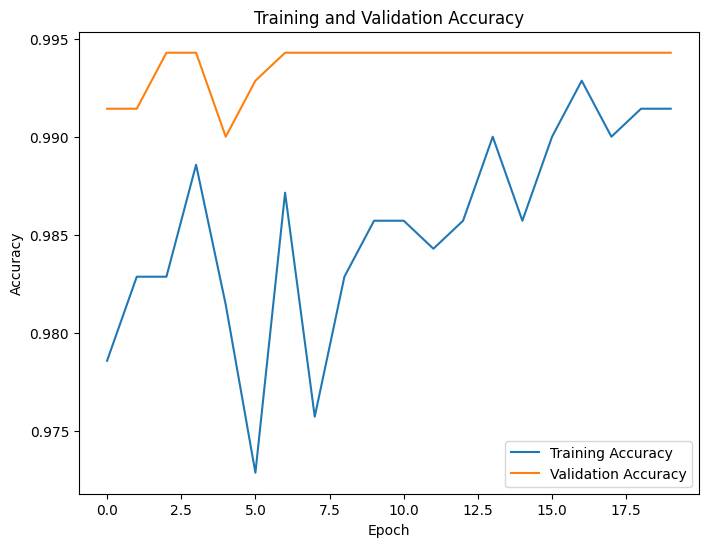

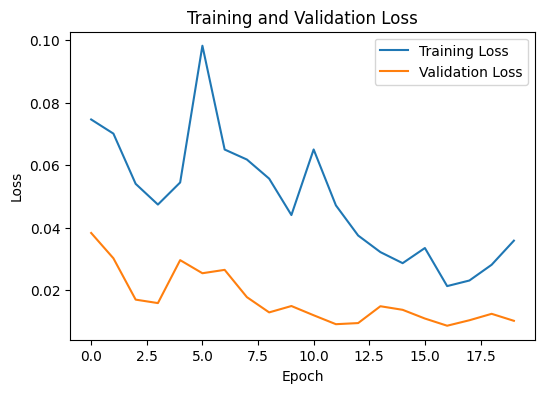

In [ ]:
import matplotlib.pyplot as plt

# Retrieve training history from the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 700 images belonging to 3 classes.
22/22 [==============================] - 2s 96ms/step


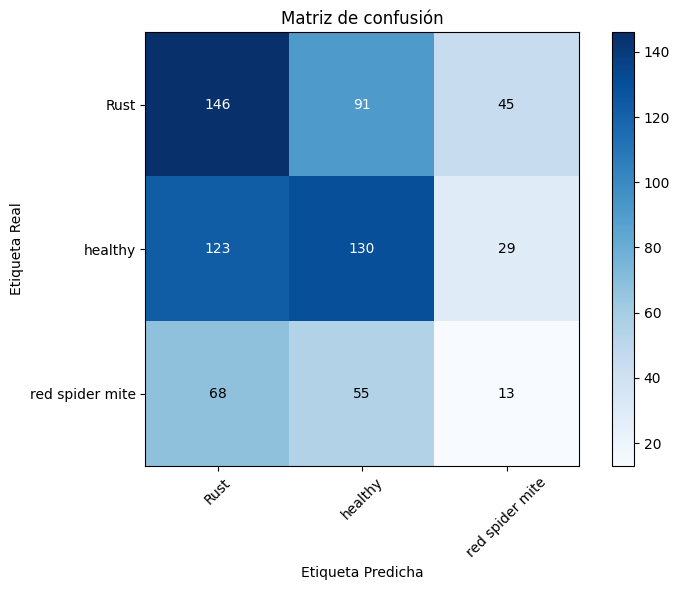

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener las etiquetas reales y las predicciones del modelo en el conjunto de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
class_names = test_generator.class_indices

# Crear el gráfico de matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

# Anotar los valores en la matriz de confusión
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


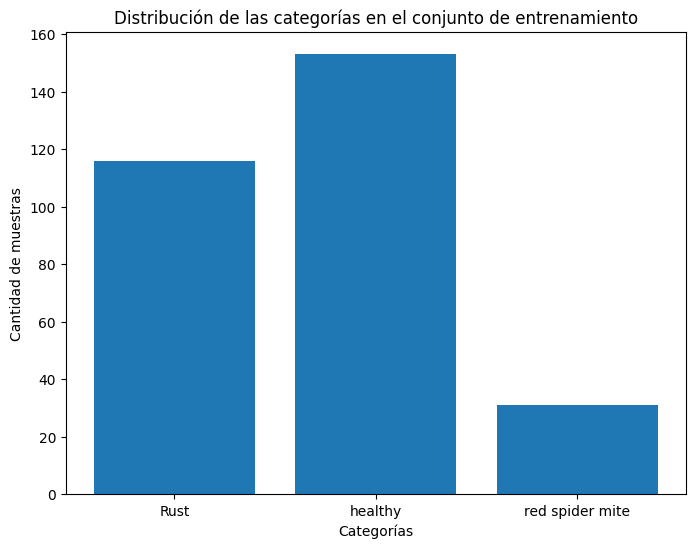

In [17]:
import matplotlib.pyplot as plt

# Obtener la cantidad de muestras en cada categoría
train_class_counts = train_generator.classes
unique_classes, class_counts = np.unique(train_class_counts, return_counts=True)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts)
plt.xticks(unique_classes, class_names)
plt.xlabel('Categorías')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de las categorías en el conjunto de entrenamiento')
plt.show()


#Probando el modelo

Saving C1P13H2.jpg to C1P13H2.jpg
1/1 [==============================] - 0s 77ms/step


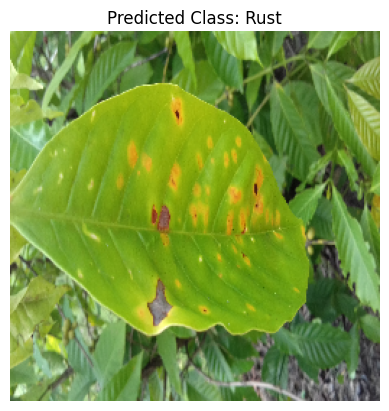

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

# Cargar el modelo previamente entrenado
model = tf.keras.models.load_model('/content/modelo.h5')

# Solicitar al usuario que seleccione una imagen
uploaded = files.upload()

# Obtener la ruta de la imagen cargada
image_path = next(iter(uploaded))

# Cargar la imagen y redimensionarla al tamaño requerido
img = image.load_img(image_path, target_size=(img_height, img_width))

# Convertir la imagen a un arreglo numpy
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocesar la imagen
img_array /= 255.

# Realizar la clasificación
predictions = model.predict(img_array)

# Obtener el índice de la clase con mayor probabilidad
predicted_index = np.argmax(predictions[0])

# Obtener el nombre de la clase predicha
class_names = ['Rust', 'Healthy', 'Red Spider Mite']
predicted_class = class_names[predicted_index]

# Mostrar la imagen y la predicción
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}')
plt.show()



In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Directorio que contiene las imágenes de prueba
test_dir = '/content/datos/redimensionadas/test'

# Cargar el modelo previamente entrenado
model = tf.keras.models.load_model('/content/modelo.h5')

# Obtener las clases de enfermedades
class_names = ['Rust', 'Healthy', 'Red Spider Mite']

# Iterar sobre los directorios en el directorio de prueba
for dir_name in os.listdir(test_dir):
    dir_path = os.path.join(test_dir, dir_name)

    # Iterar sobre las imágenes en el directorio
    for filename in os.listdir(dir_path):
        # Obtener la ruta completa de la imagen
        img_path = os.path.join(dir_path, filename)

        # Cargar la imagen y redimensionarla al tamaño requerido
        img = image.load_img(img_path, target_size=(256, 256))

        # Convertir la imagen a un arreglo numpy
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Preprocesar la imagen
        img_array /= 255.

        # Realizar la clasificación
        predictions = model.predict(img_array)

        # Obtener el índice de la clase con mayor probabilidad
        predicted_index = np.argmax(predictions[0])

        # Obtener el nombre de la clase predicha
        predicted_class = class_names[predicted_index]

        # Mostrar el nombre del directorio y la imagen
        print(f"Directorio: {dir_name}, Imagen: {filename}, Predicción: {predicted_class}")



1/1 [==============================] - 0s 107ms/step
Directorio: Rust, Imagen: C1P19H2.jpg, Predicción: Rust
1/1 [==============================] - 0s 28ms/step
Directorio: Rust, Imagen: C1P35E2.jpg, Predicción: Rust
1/1 [==============================] - 0s 32ms/step
Directorio: Rust, Imagen: C3P15H2.jpg, Predicción: Rust
1/1 [==============================] - 0s 28ms/step
Directorio: Rust, Imagen: C2P19H1.jpg, Predicción: Rust
1/1 [==============================] - 0s 30ms/step
Directorio: Rust, Imagen: C2P11H2.jpg, Predicción: Rust
1/1 [==============================] - 0s 33ms/step
Directorio: Rust, Imagen: C3P16H1.jpg, Predicción: Rust
1/1 [==============================] - 0s 33ms/step
Directorio: Rust, Imagen: C1P10E2.jpg, Predicción: Rust
1/1 [==============================] - 0s 85ms/step
Directorio: Rust, Imagen: C1P7E2.jpg, Predicción: Rust
1/1 [==============================] - 0s 79ms/step
Directorio: Rust, Imagen: C3P2H2.jpg, Predicción: Rust
1/1 [========================